In [1]:
import numpy as np
from numpy import ndarray
import math
import os
import csv
from skimage import io
from skimage import morphology 
from skimage import filters
from skimage import measure
from skimage import exposure
from skimage.morphology import watershed
from skimage.morphology import extrema
from skimage.feature import peak_local_max
from scipy import ndimage
from skimage import segmentation
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

In [2]:
imdir = '080316_w4'

files = os.listdir(imdir)
images = []

for names in files:
    if names.endswith('.tif'):
        images.append(names)

n = len(images)

imnames = []
for i in range(0,n):
    imnames.append(imdir + '/uncompressed_' + str(i) + '.tif')
    
area_pix = [0]*n
radius_um = [0]*n
minor_axis = [0]*n
major_axis = [0]*n
ratio = [0]*n
angle = [0]*n
COM_r = [0]*n
COM_c = [0]*n

#ultimately have these come from UI
imaging_time = 40
length_conversion = 450

time = np.linspace(0,imaging_time,num=n)

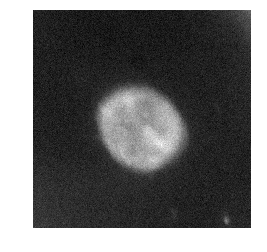

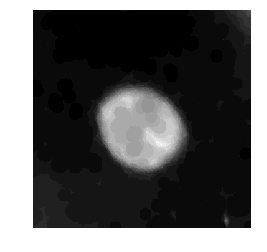

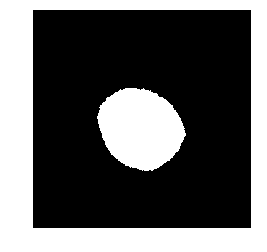

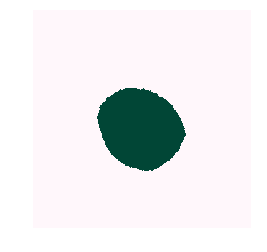

1


In [23]:
#this is for making sure settings work for first image -- replace with UI
i = 0
im = io.imread(imnames[i], as_grey=True)
im_rows = im.shape[0]
im_cols = im.shape[1]

im_crop = im[(680-175):(680+175),(750-175):(750+175)]

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(im_crop, cmap=plt.cm.gray)
ax.axis('off')
plt.show()

se = morphology.disk(10)
closed = morphology.closing(im_crop,se)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(closed, cmap=plt.cm.gray)
ax.axis('off')
plt.show()

level = filters.threshold_otsu(closed)
bw = closed > level  
bw2 = morphology.remove_small_objects(bw,50)
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(bw2, cmap=plt.cm.gray)
ax.axis('off')
plt.show()
    
distance = ndimage.distance_transform_edt(bw2)

#local_maxi = peak_local_max(distance,indices = False, footprint =np.ones((3,3)), labels =bw2)

h = 0.1
local_maxi = extrema.h_maxima(distance, h)
    
markers = morphology.label(local_maxi)
markers_ws = markers
labels_ws = watershed(-distance,markers_ws,mask=bw2, compactness =0)

fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(labels_ws, cmap=plt.cm.PuBuGn)
ax.axis('off')
plt.show()

props = measure.regionprops(labels_ws)
print(len(props))

In [24]:
def segment_and_measure(i,im,h,af):
    se = morphology.disk(10)
    closed = morphology.closing(im,se)
    
    level = filters.threshold_otsu(closed)
    bw = closed > level
    
    bw2 = morphology.remove_small_objects(bw,af)
    
    distance = ndimage.distance_transform_edt(bw2)
    
    local_maxi = extrema.h_maxima(distance, h)
    
    markers = morphology.label(local_maxi)
    markers_ws = markers
    labels_ws = watershed(-distance,markers_ws,mask=bw2, compactness =0)
    
    props = measure.regionprops(labels_ws)

    temp = 0
    for j in range(0,len(props)):
        if props[j].area > temp:
            temp = props[j].area
            biggest = j
        
    area_pix[i] = props[biggest].area
    major_axis[i] = props[biggest].major_axis_length
    minor_axis[i] = props[biggest].minor_axis_length
    angle[i] = props[biggest].orientation    #in rad, -pi/2 to pi/2
    centroid = props[biggest].centroid
    COM_r[i] = centroid[0]
    COM_c[i] = centroid[1]

In [25]:
def draw_ellipse(i, im):
    #draw fitted ellipse
    t = np.linspace(0,2*math.pi,num=50)
    a = major_axis[i]/2
    b = minor_axis[i]/2
    Xc = COM_c[i]
    Yc = COM_r[i]
    phi = -angle[i]
    ellipx = Xc + a*np.cos(t)*np.cos(phi) - b*np.sin(t)*np.sin(phi)
    ellipy = Yc + a*np.cos(t)*np.sin(phi) + b*np.sin(t)*np.cos(phi)

    #draw lines along the axes
    xMajor = [Xc - a*np.cos(phi), Xc + a*np.cos(phi)]
    yMajor = [Yc - a*np.sin(phi), Yc + a*np.sin(phi)]

    xMinor = [Xc - b*np.cos(phi - math.pi/2), Xc + b*np.cos(phi - math.pi/2)]
    yMinor = [Yc - b*np.sin(phi - math.pi/2), Yc + b*np.sin(phi - math.pi/2)]

    #overlay cropped im and ellipse fit
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(im, cmap=plt.cm.gray)
    ax.plot(ellipx,ellipy, color ='m', linewidth = 2.0)
    ax.plot(xMajor,yMajor, color ='m', linewidth = 2.0)
    ax.plot(xMinor,yMinor, color ='m', linewidth = 2.0)
    ax.axis('off')
    plt.show()

In [26]:
def plot():
    area_conversion = length_conversion**2
    
    for i in range(0,n):
        radius_um[i] = math.sqrt((area_pix[i]/area_conversion)/math.pi) * 1000
        
    for i in range(0,n):
        ratio[i] = minor_axis[i]/major_axis[i]
    
    #plot radius, aspect ratio, angle vs time
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(time,radius_um, '.:')
    plt.show()
    
    #fig, ax = plt.subplots(figsize=(10, 5))
    #ax.plot(time,ratio, '.:')
    #plt.show()

    #fig, ax = plt.subplots(figsize=(10, 5))
    #ax.plot(time,angle, '.:')
    #plt.show()

In [30]:
def save():
    save_file = 'test.csv' #will need to generalize
    headers = ['Time(hr)', 'Radius(um)', 'Aspect Ratio(1 is circle)', 'Angle(rad)']
    
    with open(save_file, 'w', newline='') as csvfile:
        filewriter = csv.writer(csvfile) #figure out if these settings make sense
        filewriter.writerow(headers)
        
        for i in range(0,n):
            filewriter.writerow([time[i], radius_um[i], ratio[i], angle[i]])

In [28]:
def main():
    
    h = 0.5
    af = 50
    ideal_crop = 175
    com_r = 680 #ultimately get these from cropping user input
    com_c = 750
    
    for i in range(0,n):
        im = io.imread(imnames[i], as_grey=True)

        crop_r = min(ideal_crop, im_rows-com_r, com_r-1)
        crop_c = min(ideal_crop, im_cols-com_c, com_c-1)
        im_crop = im[(com_r-crop_r):(com_r+crop_r),(com_c-crop_c):(com_c+crop_c)] 
        
        segment_and_measure(i,im_crop,h,af)
        
        if i%72==0:
            draw_ellipse(i,im_crop)
        
        position_r = int(com_r - crop_r - 1 + COM_r[i]) #position in current uncropped image
        position_c = int(com_c - crop_c - 1 + COM_c[i])
        
        com_r = position_r #update, for positioning next cropping window
        com_c = position_c 
    
    plot()
    save()

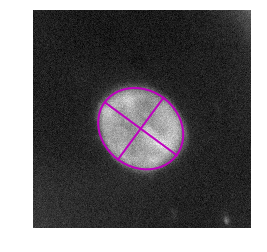

C:\Users\kmk92\Anaconda3\lib\site-packages\skimage\morphology\misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


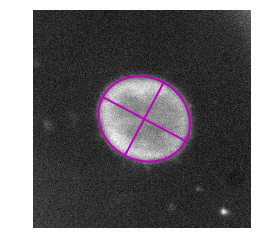

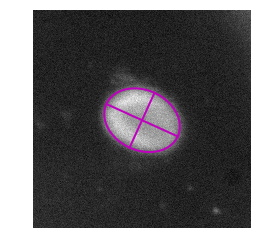

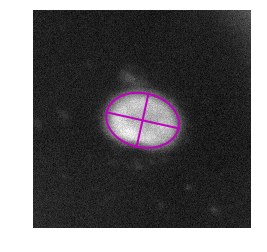

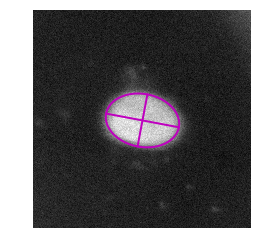

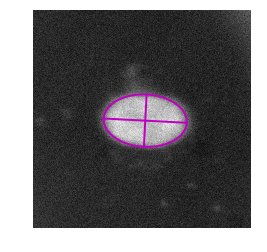

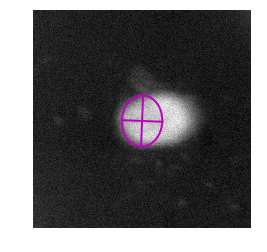

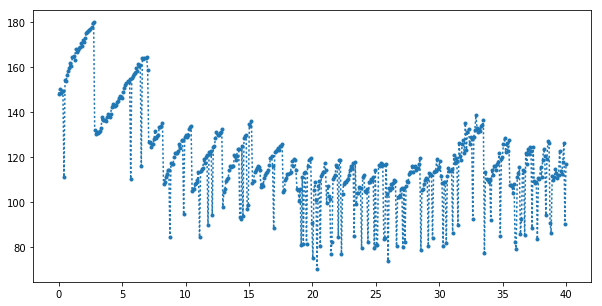

In [29]:
main()

In [3]:
x = []
x = [0]
x.append(1)
print(x[0])
print(x[1])
print(len(x))

0
1
2


In [3]:
print(imnames[0])

080316_w4/uncompressed_0.tif


In [4]:
x = []
x.append(0)
x[0] = 0

In [5]:
print(len(x))

1


In [6]:
y = []
print(len(y))

0
